In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

X_train = pd.read_csv('datamart/X_train_clipped_scaled.csv').values
y_train = pd.read_csv('datamart/y_lactose_train.csv').values
X_test = pd.read_csv('datamart/X_test_clipped_scaled.csv').values
y_test = pd.read_csv('datamart/y_lactose_test.csv').values

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


In [ ]:
optimizer = []

Early stopping at epoch 749
Best MSE: 0.004 at epoch 739
Best RMSE: 0.063


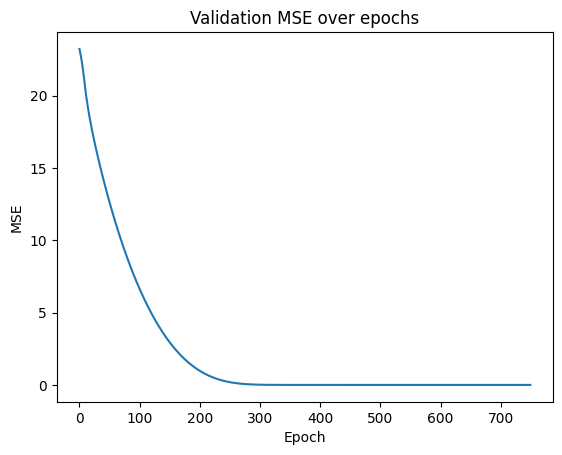

In [5]:
model = nn.Sequential(
    nn.Linear(12, 1),
    nn.ReLU(),
    nn.Linear(1, 1)
)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf
best_weights = None
history = []

# Early stopping parameters
patience = 10  # how many epochs to wait after last improvement
best_epoch = 0

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # Take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()
            # Print progress
            bar.set_postfix(mse=float(loss))
    # Evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch
    elif epoch - best_epoch >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore model to the best weights
model.load_state_dict(best_weights)
print(f"Best MSE: {best_mse:.3f} at epoch {best_epoch}")
print(f"Best RMSE: {np.sqrt(best_mse):.3f}")
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation MSE over epochs')
plt.show()

# model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples
#     for i in range(5):
#         X_sample = X_test[i: i+1]
#         X_sample = scaler.transform(X_sample)
#         X_sample = torch.tensor(X_sample, dtype=torch.float32)
#         y_pred = model(X_sample)
#         print(f"{X_test[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

Fold 1
Early stopping at epoch 966
Best MSE for fold 1: 0.005
Best RMSE for fold 1: 0.070
Fold 2
Early stopping at epoch 521
Best MSE for fold 2: 0.005
Best RMSE for fold 2: 0.070
Fold 3
Early stopping at epoch 979
Best MSE for fold 3: 0.004
Best RMSE for fold 3: 0.062
Fold 4
Early stopping at epoch 573
Best MSE for fold 4: 0.003
Best RMSE for fold 4: 0.054
Fold 5
Early stopping at epoch 350
Best MSE for fold 5: 0.003
Best RMSE for fold 5: 0.055
Average MSE: 0.004
Average RMSE: 0.062


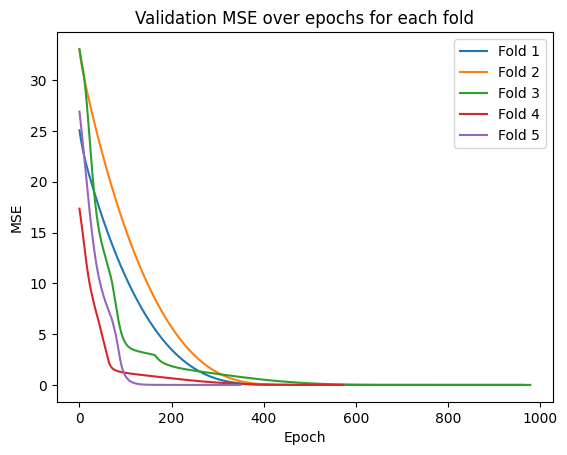

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
def create_model():
    return nn.Sequential(
        nn.Linear(12, 1),
        nn.ReLU(),
        nn.Linear(1, 1),

    )
loss_fn = nn.MSELoss()
learning_rate = 0.001
n_epochs = 1000   # number of epochs to run
batch_size = 10   # size of each batch

# Early stopping parameters
patience = 10  # how many epochs to wait after last improvement

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold+1}")
    X_train_cross, X_val = X_train[train_idx], X_train[val_idx]
    y_train_cross, y_val = y_train[train_idx], y_train[val_idx]
    
    model = create_model()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_mse = np.inf
    best_weights = None
    history = []
    best_epoch = 0
    
    batch_start = torch.arange(0, len(X_train_cross), batch_size)
    
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # Take a batch
                X_batch = X_train_cross[start:start+batch_size]
                y_batch = y_train_cross[start:start+batch_size]
                # Forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                # Update weights
                optimizer.step()
                # Print progress
                bar.set_postfix(mse=float(loss))
        
        # Evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        mse = loss_fn(y_pred, y_val)
        mse = float(mse)
        history.append(mse)
        
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        elif epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Restore model to the best weights
    model.load_state_dict(best_weights)
    fold_results.append(best_mse)
    print(f"Best MSE for fold {fold+1}: {best_mse:.3f}")
    print(f"Best RMSE for fold {fold+1}: {np.sqrt(best_mse):.3f}")
    plt.plot(history, label=f'Fold {fold+1}')

# Print final results
print(f"Average MSE: {np.mean(fold_results):.3f}")
print(f"Average RMSE: {np.sqrt(np.mean(fold_results)):.3f}")

# Plotting the MSE history for each fold
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation MSE over epochs for each fold')
plt.legend()
plt.show()





In [4]:
model = create_model()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_start = torch.arange(0, len(X_train_cross), batch_size)

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # Take a batch
            X_batch = X_train_cross[start:start+batch_size]
            y_batch = y_train_cross[start:start+batch_size]
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()
            # Print progress
            bar.set_postfix(mse=float(loss))
    
    # Evaluate accuracy at end of each epoch
model.eval()
y_pred = model(X_test)
mse = loss_fn(y_pred, y_test)
mse = float(mse)


print(np.sqrt((mse)))

0.05601731942219727
